In [2]:
import torch
import pandas as pd
import numpy as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
dataset = Planetoid(root='.',name='Cora')
data = dataset[0]

In [4]:
degrees = degree(data.edge_index[0]).numpy() #각 노드의 이웃갯수
numbers = Counter(degrees) #갯수만큼 딕셔너리 형태로 저장

<BarContainer object of 37 artists>

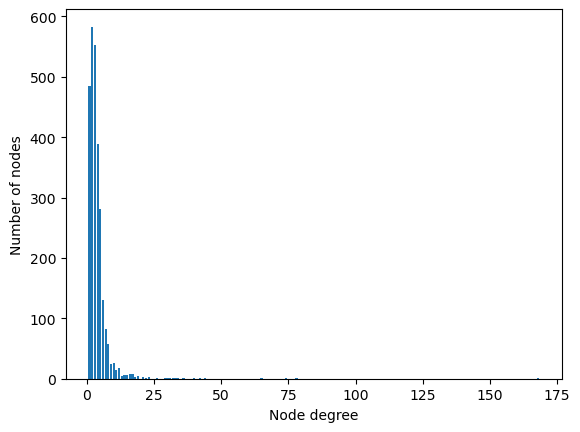

In [5]:
fig,ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),numbers.values()) #각 차수가 몇개 있는지

위 그래프를 보면 노드의 차수가 치우쳐져있음=>(따라서, 차수의 정규화가 필요함)

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [7]:
def accuracy(pred_y,y):
    return ((pred_y==y).sum()/len(y)).item()

In [27]:
class GCN(torch.nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in,dim_h)
        self.gcn2 = GCNConv(dim_h,dim_out)
    
    def forward(self,x,edge_index):
        h = self.gcn1(x,edge_index)
        h = F.relu(h)
        h = self.gcn2(h,edge_index)
        return h
    
    def fit(self,data,epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x,data.edge_index) #로짓값
            loss = criterion(out[data.train_mask],data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch%20==0:
                val_loss = criterion(out[data.val_mask],data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train_Loss : {loss:.3f} | Train_Acc : {acc*100:>5.2f} | Val_Loss : {val_loss:.3f} | Val_Acc : {val_acc:>5.2f}')
    
    def test(self,data):
        torch.no_grad()
        self.eval()
        out = self(data.x,data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1),data.y[data.test_mask])
        return acc
        

In [28]:
gcn = GCN(dataset.num_features,16,dataset.num_classes)
print(gcn)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)


In [29]:
gcn.fit(data,epochs=100)

Epoch   0 | Train_Loss : 1.941 | Train_Acc : 17.14 | Val_Loss : 1.935 | Val_Acc :  0.19
Epoch  20 | Train_Loss : 0.192 | Train_Acc : 100.00 | Val_Loss : 0.839 | Val_Acc :  0.76
Epoch  40 | Train_Loss : 0.023 | Train_Acc : 100.00 | Val_Loss : 0.731 | Val_Acc :  0.77
Epoch  60 | Train_Loss : 0.019 | Train_Acc : 100.00 | Val_Loss : 0.707 | Val_Acc :  0.78
Epoch  80 | Train_Loss : 0.020 | Train_Acc : 100.00 | Val_Loss : 0.699 | Val_Acc :  0.78
Epoch 100 | Train_Loss : 0.018 | Train_Acc : 100.00 | Val_Loss : 0.700 | Val_Acc :  0.77


In [30]:
Test_acc = gcn.test(data)
print(f'Test_acc : {Test_acc*100:.5f}')

Test_acc : 79.20000
